# Comparison


In [28]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [29]:
from scripts.params import get_params
from scripts.aux_functions import get_all_results_matching, subset_of_columns, clean_modelname

params = get_params()

In [30]:
from scripts.epftoolbox_dm_gw import DM, plot_multivariate_DM_test, GW, plot_multivariate_GW_test

In [31]:
dataroute = params["dataroute"]
resultsroute = params["resultsroute"]
dumproute = params["dumproute"]
graphsroute = params["graphsroute"]
dmroute=params["dmroute"]
gwroute=params["gwroute"]

In [32]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [33]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)
    
df_test.index=pd.to_datetime(df_test.index.copy())

In [34]:
all_forecasts = get_all_results_matching(params["resultsroute"], ["best_forecasts"])
all_residuals = get_all_results_matching(params["resultsroute"], ["best_residuals"])

{'GARCH_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\AR_^MERV\\GARCH_AR_^MERV_aic_best_forecasts.pickle', 'GARCH_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\AR_^MERV\\GARCH_AR_^MERV_bic_best_forecasts.pickle', 'HMM_multiv_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_multiv_AR_^MERV_aic_best_forecasts.pickle', 'HMM_multiv_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_multiv_AR_^MERV_bic_best_forecasts.pickle', 'HMM_univ_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_univ_AR_^MERV_aic_best_forecasts.pickle', 'HMM_univ_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_univ_AR_^MERV_bic_best_forecasts.pickle', 'HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle', 'HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle', 'VAR_multiv_AR_^MERV_aic_best_forecasts.pickle': '.

In [35]:
def get_only_log_rets(dict_with_dfs: dict, stock: str):
    if type(dict_with_dfs[stock]) == pd.Series:
        # univariate models are saved as series
        df = pd.DataFrame(dict_with_dfs[stock])

    else:
        try:
            # multivariate models are saved as dataframes
            df = pd.DataFrame(dict_with_dfs[stock][f"{stock}_log_rets"])
        except:  # TODO: SACAR ESTO! Es un chanchullo pq hay algunas que son guardadas como None
            pass
    return df

In [36]:
def create_df_from_results_dict(results_dict:dict, substring_to_replace:str):
    created_df = pd.DataFrame()

    for name, dir in results_dict.items():
        dict_with_dfs = pd.read_pickle(dir)
        print(name)

        for stock in dict_with_dfs.keys():
            df = get_only_log_rets(dict_with_dfs, stock)

            modelname = clean_modelname(name, substring_to_replace, tablename=params["tablename"])

            df.columns = [modelname + "_" + stock]

            created_df = pd.merge(
                created_df, df, left_index=True, right_index=True, how="outer"
            )

    created_df.index = pd.to_datetime(created_df.index)
    created_df = created_df[created_df.index > start_test]
    return created_df

In [37]:
forecasts_df = create_df_from_results_dict(all_forecasts, "forecasts")

GARCH_AR_^MERV_aic_best_forecasts.pickle
GARCH_AR_^MERV_bic_best_forecasts.pickle
HMM_multiv_AR_^MERV_aic_best_forecasts.pickle
HMM_multiv_AR_^MERV_bic_best_forecasts.pickle
HMM_univ_AR_^MERV_aic_best_forecasts.pickle
HMM_univ_AR_^MERV_bic_best_forecasts.pickle
HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle
HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle
VAR_multiv_AR_^MERV_aic_best_forecasts.pickle
VAR_multiv_AR_^MERV_bic_best_forecasts.pickle
VAR_with_vol_AR_^MERV_aic_best_forecasts.pickle
VAR_with_vol_AR_^MERV_bic_best_forecasts.pickle


In [38]:
forecasts_df = pd.concat([forecasts_df, subset_of_columns(df_test, "log_rets")])

In [39]:
residual_df = create_df_from_results_dict(all_residuals, "residuals")

GARCH_AR_^MERV_aic_best_residuals.pickle
GARCH_AR_^MERV_bic_best_residuals.pickle
HMM_multiv_AR_^MERV_aic_best_residuals.pickle
HMM_multiv_AR_^MERV_bic_best_residuals.pickle
HMM_univ_AR_^MERV_aic_best_residuals.pickle
HMM_univ_AR_^MERV_bic_best_residuals.pickle
HMM_with_vol_AR_^MERV_aic_best_residuals.pickle
HMM_with_vol_AR_^MERV_bic_best_residuals.pickle
VAR_multiv_AR_^MERV_aic_best_residuals.pickle
VAR_multiv_AR_^MERV_bic_best_residuals.pickle
VAR_with_vol_AR_^MERV_aic_best_residuals.pickle
VAR_with_vol_AR_^MERV_bic_best_residuals.pickle


In [40]:
lower_date=pd.to_datetime(params["start_test"])+pd.Timedelta(days=1)
higher_date=pd.to_datetime(params["end_test"])-pd.Timedelta(days=1)
residual_df=residual_df[lower_date:higher_date].copy()
df_test = df_test[lower_date:higher_date].copy()
residual_df.head()

,GARCH_aic_MERV_USD,GARCH_aic_^MERV,GARCH_aic_GGAL.BA,GARCH_aic_GGAL,GARCH_aic_YPFD.BA,GARCH_aic_YPF,GARCH_aic_EDN.BA,GARCH_aic_EDN,GARCH_aic_BMA.BA,GARCH_aic_BMA,GARCH_aic_BBAR.BA,GARCH_aic_BBAR,GARCH_bic_MERV_USD,GARCH_bic_^MERV,GARCH_bic_GGAL.BA,GARCH_bic_GGAL,GARCH_bic_YPFD.BA,GARCH_bic_YPF,GARCH_bic_EDN.BA,GARCH_bic_EDN,GARCH_bic_BMA.BA,GARCH_bic_BMA,GARCH_bic_BBAR.BA,GARCH_bic_BBAR,HMM_multiv_aic_MERV_USD,HMM_multiv_aic_^MERV,HMM_multiv_aic_GGAL.BA,HMM_multiv_aic_GGAL,HMM_multiv_aic_YPFD.BA,HMM_multiv_aic_YPF,HMM_multiv_aic_EDN.BA,HMM_multiv_aic_EDN,HMM_multiv_aic_BMA.BA,HMM_multiv_aic_BMA,HMM_multiv_aic_BBAR.BA,HMM_multiv_aic_BBAR,HMM_multiv_bic_MERV_USD,HMM_multiv_bic_^MERV,HMM_multiv_bic_GGAL.BA,HMM_multiv_bic_GGAL,HMM_multiv_bic_YPFD.BA,HMM_multiv_bic_YPF,HMM_multiv_bic_EDN.BA,HMM_multiv_bic_EDN,HMM_multiv_bic_BMA.BA,HMM_multiv_bic_BMA,HMM_multiv_bic_BBAR.BA,HMM_multiv_bic_BBAR,HMM_univ_aic_MERV_USD,HMM_univ_aic_^MERV,HMM_univ_aic_GGAL.BA,HMM_univ_aic_GGAL,HMM_univ_aic_YPFD.BA,HMM_univ_aic_YPF,HMM_univ_aic_EDN.BA,HMM_univ_aic_EDN,HMM_univ_aic_BMA.BA,HMM_univ_aic_BMA,HMM_univ_aic_BBAR.BA,HMM_univ_aic_BBAR,HMM_univ_bic_MERV_USD,HMM_univ_bic_^MERV,HMM_univ_bic_GGAL.BA,HMM_univ_bic_GGAL,HMM_univ_bic_YPFD.BA,HMM_univ_bic_YPF,HMM_univ_bic_EDN.BA,HMM_univ_bic_EDN,HMM_univ_bic_BMA.BA,HMM_univ_bic_BMA,HMM_univ_bic_BBAR.BA,HMM_univ_bic_BBAR,HMM_with_vol_aic_MERV_USD,HMM_with_vol_aic_^MERV,HMM_with_vol_aic_GGAL.BA,HMM_with_vol_aic_GGAL,HMM_with_vol_aic_YPFD.BA,HMM_with_vol_aic_YPF,HMM_with_vol_aic_EDN.BA,HMM_with_vol_aic_EDN,HMM_with_vol_aic_BMA.BA,HMM_with_vol_aic_BMA,HMM_with_vol_aic_BBAR.BA,HMM_with_vol_aic_BBAR,HMM_with_vol_bic_MERV_USD,HMM_with_vol_bic_^MERV,HMM_with_vol_bic_GGAL.BA,HMM_with_vol_bic_GGAL,HMM_with_vol_bic_YPFD.BA,HMM_with_vol_bic_YPF,HMM_with_vol_bic_EDN.BA,HMM_with_vol_bic_EDN,HMM_with_vol_bic_BMA.BA,HMM_with_vol_bic_BMA,HMM_with_vol_bic_BBAR.BA,HMM_with_vol_bic_BBAR,VAR_multiv_aic_MERV_USD,VAR_multiv_aic_^MERV,VAR_multiv_aic_GGAL.BA,VAR_multiv_aic_GGAL,VAR_multiv_aic_YPFD.BA,VAR_multiv_aic_YPF,VAR_multiv_aic_EDN.BA,VAR_multiv_aic_EDN,VAR_multiv_aic_BMA.BA,VAR_multiv_aic_BMA,VAR_multiv_aic_BBAR.BA,VAR_multiv_aic_BBAR,VAR_multiv_bic_MERV_USD,VAR_multiv_bic_^MERV,VAR_multiv_bic_GGAL.BA,VAR_multiv_bic_GGAL,VAR_multiv_bic_YPFD.BA,VAR_multiv_bic_YPF,VAR_multiv_bic_EDN.BA,VAR_multiv_bic_EDN,VAR_multiv_bic_BMA.BA,VAR_multiv_bic_BMA,VAR_multiv_bic_BBAR.BA,VAR_multiv_bic_BBAR,VAR_with_vol_aic_MERV_USD,VAR_with_vol_aic_^MERV,VAR_with_vol_aic_GGAL.BA,VAR_with_vol_aic_GGAL,VAR_with_vol_aic_YPFD.BA,VAR_with_vol_aic_YPF,VAR_with_vol_aic_EDN.BA,VAR_with_vol_aic_EDN,VAR_with_vol_aic_BMA.BA,VAR_with_vol_aic_BMA,VAR_with_vol_aic_BBAR.BA,VAR_with_vol_aic_BBAR,VAR_with_vol_bic_MERV_USD,VAR_with_vol_bic_^MERV,VAR_with_vol_bic_GGAL.BA,VAR_with_vol_bic_GGAL,VAR_with_vol_bic_YPFD.BA,VAR_with_vol_bic_YPF,VAR_with_vol_bic_EDN.BA,VAR_with_vol_bic_EDN,VAR_with_vol_bic_BMA.BA,VAR_with_vol_bic_BMA,VAR_with_vol_bic_BBAR.BA,VAR_with_vol_bic_BBAR
2023-06-01,0.022472,0.026022,0.021286,0.015645,0.031394,0.023439,0.046265,0.034434,0.055436,0.043018,0.037460,0.034064,0.022451,0.026022,0.021076,0.015717,0.031544,0.023439,0.046265,0.034645,0.055761,0.043025,0.037459,0.033835,0.024698,0.030113,0.023455,0.016188,0.036745,0.025566,0.052277,0.031486,0.052954,0.041367,0.040849,0.032405,0.022821,0.030133,0.022022,0.014246,0.036277,0.024896,0.051232,0.028974,0.054288,0.038728,0.039417,0.031227,0.022436,0.026794,0.021310,0.016615,0.031943,0.023704,0.037611,0.031630,0.055510,0.041000,0.039534,0.033557,0.022436,0.026794,0.022685,0.016615,0.032336,0.024999,0.048033,0.030821,0.055510,0.042724,0.039534,0.034412,0.024813,0.029393,0.018720,0.012763,0.031265,0.020459,0.051209,0.025551,0.055450,0.037287,0.033036,0.033970,0.024818,0.025184,0.021974,0.016741,0.035540,0.021035,0.047740,0.030860,0.055450,0.041429,0.039871,0.028577,-0.012001,-0.016984,-0.005038,-0.007386,-0.024115,-0.020741,0.015157,0.011159,-0.024275,-0.032690,-0.035082,-0.023184,-0.004391,-0.00506

In [41]:
# estadisticos de nans
((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)

GARCH_aic_MERV_USD    0.0
GARCH_aic_^MERV       0.0
GARCH_aic_GGAL.BA     0.0
GARCH_aic_GGAL        0.0
GARCH_aic_YPFD.BA     0.0
GARCH_aic_YPF         0.0
GARCH_aic_EDN.BA      0.0
GARCH_aic_EDN         0.0
GARCH_aic_BMA.BA      0.0
GARCH_aic_BMA         0.0
dtype: float64

In [42]:
# estadisticos de nans
((forecasts_df.isna().sum(axis=0) / len(forecasts_df.index)) * 100).nlargest(10)

GARCH_aic_MERV_USD    50.657895
GARCH_aic_^MERV       50.657895
GARCH_aic_GGAL.BA     50.657895
GARCH_aic_GGAL        50.657895
GARCH_aic_YPFD.BA     50.657895
GARCH_aic_YPF         50.657895
GARCH_aic_EDN.BA      50.657895
GARCH_aic_EDN         50.657895
GARCH_aic_BMA.BA      50.657895
GARCH_aic_BMA         50.657895
dtype: float64

## Separating in different stocks

In [43]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["tickerlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [44]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [45]:
for df_clean, name in zip([forecasts_by_stock, residuals_by_stock], ["forecasts", "residuals"]):
    bystockname = name + "_by_stock_" + params["tablename"] + ".pickle"
    with open(os.path.join(resultsroute, bystockname), "wb") as handle:
        pickle.dump(df_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

^MERV


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


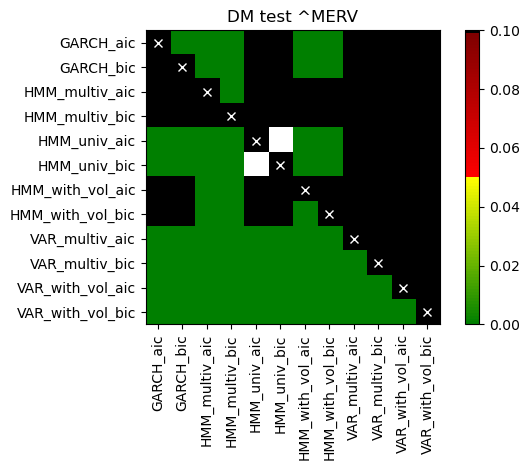

GGAL.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


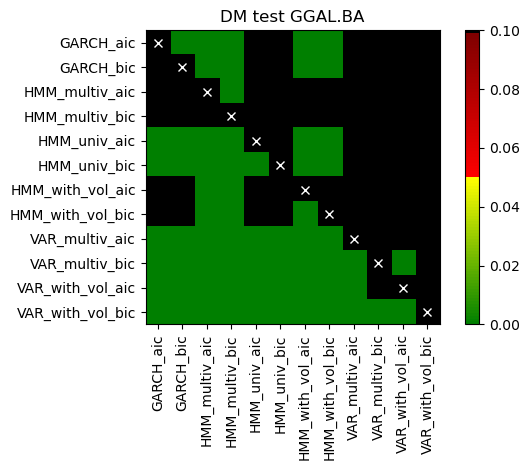

GGAL


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


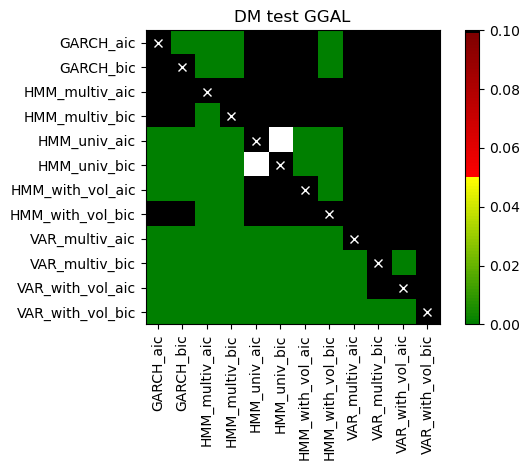

YPFD.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


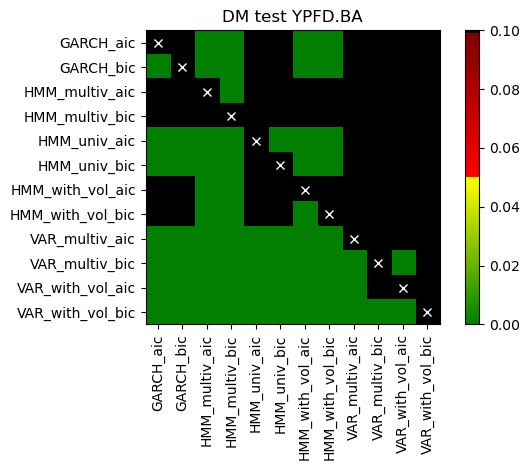

YPF


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


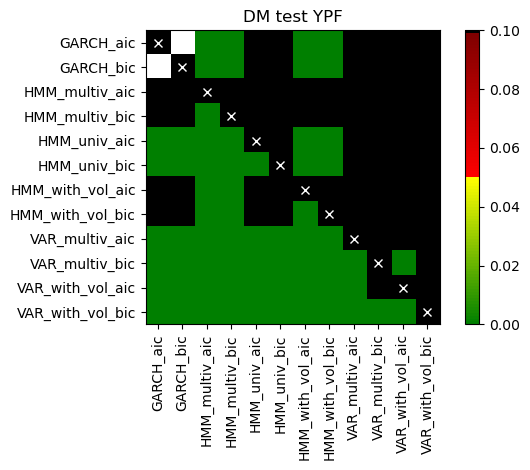

EDN.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


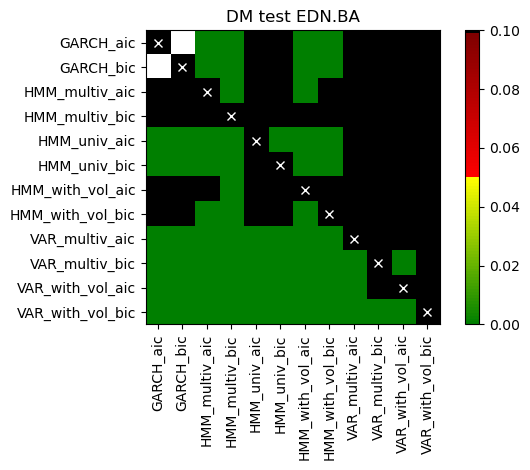

EDN


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


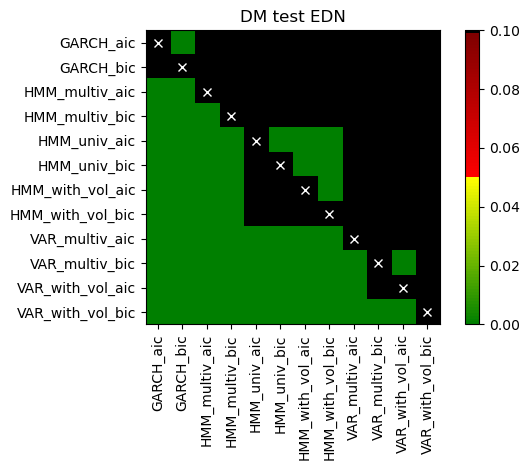

BMA.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


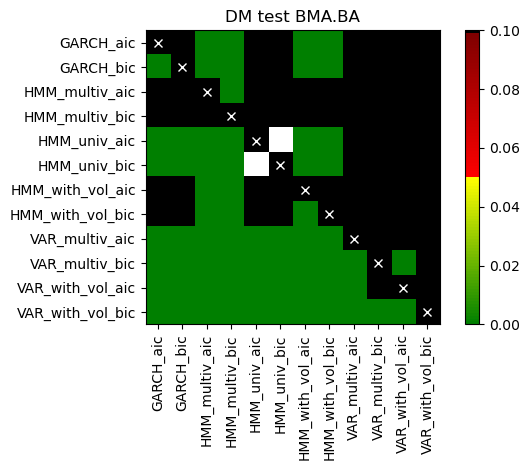

BMA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


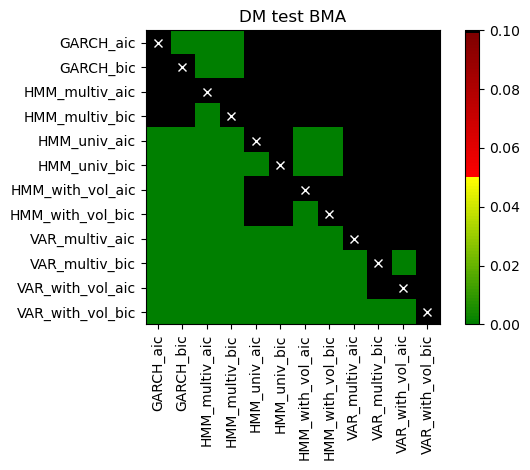

BBAR.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


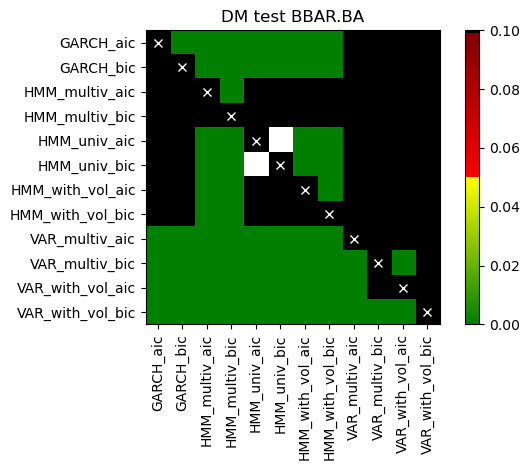

BBAR


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


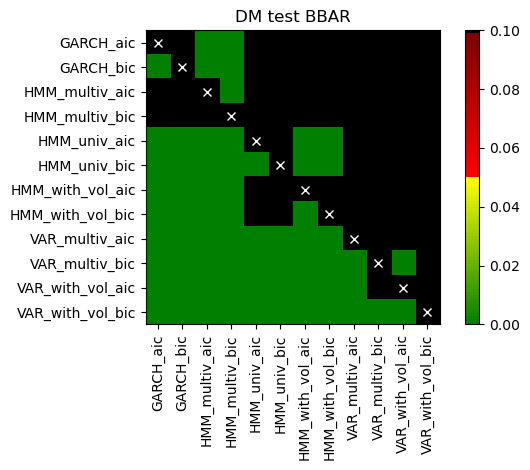

In [47]:
for stock in forecasts_by_stock.keys():
    print(stock)
    real_values=subset_of_columns(df_test, f"{stock}_log_rets")
    forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"_{stock}")   

    plot_multivariate_DM_test(real_price=real_values, 
                            forecasts=forecasts.fillna(0), 
                            title=f"DM test {stock}",
                            savefig=True,
                            path=dmroute)

In [48]:
best_models_by_stock={stock:None for stock in residuals_by_stock.keys()}

for stock, dataframe in residuals_by_stock.items():
    dataframe = delete_in_column_names(dataframe, f"_{stock}")
    metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

    for column in dataframe.columns:
        single_model=pd.DataFrame(dataframe[column])
        
        metrics_df.loc["mse", column] = (
            (single_model**2).mean().mean()
        )
        metrics_df.loc["meanabs", column] = (
            single_model.abs().mean().mean()
        )
        metrics_df.loc["medianabs", column] = (
            (single_model.abs()).median().median()
        )
    metrics_df = metrics_df * 100
    metrics_df = subset_of_columns(metrics_df, substring="", exclude="USD")
    
    best_dict={}
    for criterion in metrics_df.index:
        best_dict[criterion] = metrics_df.iloc[metrics_df.index==criterion].idxmin(axis="columns").values[0]
        
    best_models_by_stock[stock]= (metrics_df, best_dict)

In [49]:
print(params["tickerlist"][0])
best_models_by_stock[params["tickerlist"][0]][1]

^MERV


{'mse': 'VAR_multiv_aic',
 'meanabs': 'VAR_multiv_aic',
 'medianabs': 'VAR_multiv_aic'}

In [50]:
best_models_by_stock[params["tickerlist"][0]][0]

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,0.131800,0.133178,0.165158,0.157632,0.131662,0.131662,0.154692,0.155313,0.053305,0.127998,0.118424,0.148198
meanabs,2.790686,2.801741,3.090049,2.985523,2.886648,2.886648,2.930130,2.945516,1.721330,2.669034,2.576706,2.908731
medianabs,2.292540,2.281046,2.722604,2.609657,2.305330,2.305330,2.476823,2.452880,1.374278,2.057373,1.946020,2.250114


In [51]:
best_models_by_stock[params["tickerlist"][0]][0].rank(axis=1)

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,6.0,7.0,12.0,11.0,4.5,4.5,9.0,10.0,1.0,3.0,2.0,8.0
meanabs,4.0,5.0,12.0,11.0,6.5,6.5,9.0,10.0,1.0,3.0,2.0,8.0
medianabs,6.0,5.0,12.0,11.0,7.5,7.5,10.0,9.0,1.0,3.0,2.0,4.0


In [52]:
agg_df=(pd.DataFrame().reindex_like(best_models_by_stock[params["tickerlist"][0]][0]))

for asset in params["tickerlist"]:
    ranks = best_models_by_stock[asset][0].rank(axis=1)
    agg_df = agg_df.add(ranks, fill_value=0)
    
agg_df

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,88.0,94.0,120.0,115.0,43.0,50.0,81.0,79.0,13.0,53.0,32.0,90.0
meanabs,83.0,93.0,119.0,103.0,48.0,61.0,62.0,68.0,11.0,70.0,37.0,103.0
medianabs,93.0,91.0,100.0,84.0,69.0,82.0,56.0,47.0,11.0,93.0,43.0,89.0


In [53]:
agg_df.to_csv(os.path.join(resultsroute, f"""aggregate_results_df_{params["tablename"]}.csv"""))

In [54]:
criterion="mse"
print(f"Best overall performance by {criterion}")
agg_df.T.nsmallest(3, f"{criterion}").index.to_list()

Best overall performance by mse


['VAR_multiv_aic', 'VAR_with_vol_aic', 'HMM_univ_aic']